In [1]:
import gpytorch
from gpytorch.kernels import PeriodicKernel, RBFKernel, SpectralMixtureKernel
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # p(f)

### Prepare data

In [3]:
def GenerateSineData(x, freq=8., noise=0.5, seed=99):
    torch.manual_seed(seed)
    return torch.sin(freq * x) + noise * torch.randn(x.shape)

In [4]:
def GenerateGPData(x, ls=0.1, period=1., noise=0.5, seed=99, kernel=RBFKernel()):
    np.random.seed(seed)
    torch.manual_seed(seed)

    gp = ExactGPModel(
        train_x=None,
        train_y=None,
        likelihood=gpytorch.likelihoods.GaussianLikelihood(), # p(y|f)
        kernel=kernel
    )

    gp.covar_module.lengthscale = ls
    gp.covar_module.period_length=period
    gp.eval()
    f_preds = gp(x) 
    return f_preds.rsample().detach() + noise * torch.randn(len(x))

In [5]:
true_noise = 0.8
x = torch.linspace(0, 1., 200)
# y = GenerateGPData(x, seed=22, noise=true_noise, kernel=PeriodicKernel(), period=2.)
y = GenerateSineData(x, seed=22, noise=true_noise)

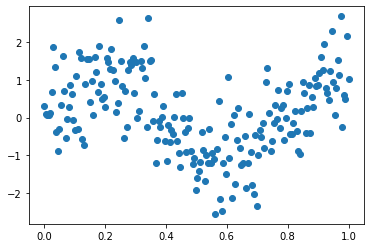

In [6]:
plt.scatter(x, y)

In [7]:
use_cuda = False
if torch.cuda.is_available():
    use_cuda = True
    x = x.cuda()
    y = y.cuda()

In [8]:
shuffle = torch.randperm(x.shape[0])
ntrain = 25
train_x = x[shuffle[:ntrain]]
eval_x = x[shuffle[ntrain:]]

train_y = y[shuffle[:ntrain]]
eval_y = y[shuffle[ntrain:]]

In [9]:
test_x = torch.linspace(0., 1., 100)

Text(0.5, 1.0, 'Train data')

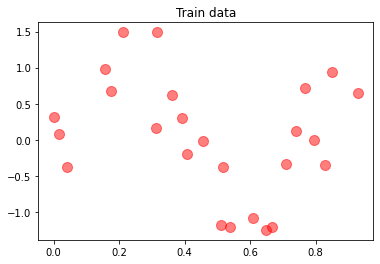

In [10]:
plt.plot(train_x.cpu(), train_y.cpu(), "ro", ms=10, alpha=0.5)
plt.title("Train data")

### Standard GP

In [11]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x) # p(f)

### Error vs MLL vs CMLL

In [12]:
def get_mll(gp, x, y):
    N = len(x)
    covar_matrix = gp.covar_module(x,x).evaluate()
    covar_matrix += gp.likelihood.noise * torch.eye(N).to(x.device)
    log_mll = - 0.5 * (y.T @ torch.inverse(covar_matrix)) @ y 
    log_mll += - 0.5 * torch.logdet(covar_matrix)
    log_mll += - 0.5 * N * np.log(2 * np.pi)

    return log_mll

def get_conditional_mll(gp, x, y, xm, ym):
    return get_mll(gp, x, y) - get_mll(gp, xm, ym)

In [13]:
lengthscale_array = torch.linspace(0.01, 0.5, 20)
period_array = torch.linspace(1., 4., 20)

nshuffle = 100
m = 20

error_array = torch.zeros(lengthscale_array.shape[0], period_array.shape[0])
mll_array = torch.zeros(lengthscale_array.shape[0], period_array.shape[0])
cmll_array = torch.zeros(lengthscale_array.shape[0], period_array.shape[0], nshuffle)

In [14]:

for ls_idx, ls in enumerate(lengthscale_array):
    for p_idx, p in enumerate(period_array):
        kernel = PeriodicKernel()
        kernel.lengthscale = ls
        kernel.period_length = p

        ## Compute Error LL  and MLL ##
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.noise_covar.noise = true_noise
        gp = ExactGPModel(
            train_x=train_x,
            train_y=train_y,
            likelihood=likelihood,
            kernel=kernel
        ).to(x.device)

        gp.eval()
        likelihood.eval()
        f_preds = gp(eval_x)
        y_preds = likelihood(f_preds)
        error_array[ls_idx, p_idx] = y_preds.log_prob(eval_y).item()
        mll_array[ls_idx, p_idx] = get_mll(gp, train_x, train_y).item()
        
for s_idx in range(nshuffle):
    order = torch.randperm(train_x.shape[0])
    xm = train_x[order[:m]]
    xstar = train_x[order[m:]]

    ym = train_y[order[:m]]
    ystar = train_y[order[m:]]

    for ls_idx, ls in enumerate(lengthscale_array):
        for p_idx, p in enumerate(period_array):
            kernel = PeriodicKernel()
            kernel.lengthscale = ls
            kernel.period_length = p

            gp = ExactGPModel(
                train_x=xm,
                train_y=ym,
                likelihood=likelihood,
                kernel=kernel
            ).to(x.device)

            cmll_array[ls_idx, p_idx, s_idx] = get_conditional_mll(gp, train_x, train_y, xm, ym).item()

In [15]:
def rescale(lst):
    lst = np.array(lst)
    return (lst - np.min(lst)) / (np.max(lst - np.min(lst)))

In [16]:
plt_cmll = rescale(cmll_array.mean(-1).detach())
plt_error = rescale(error_array.detach())
plt_mll = rescale(mll_array.detach())

Text(0.5, 1.0, 'CMLL')

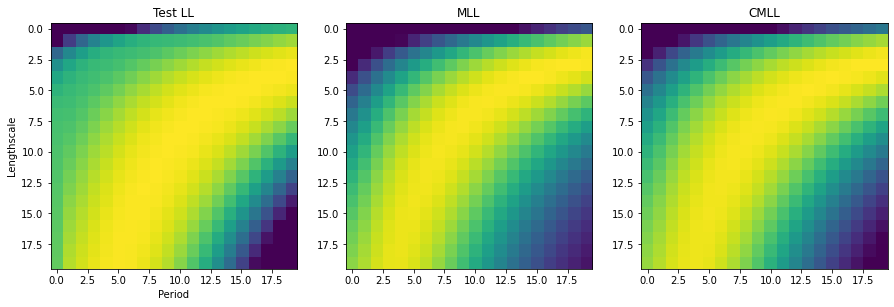

In [17]:
cmap='viridis'
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(plt_error, cmap=cmap, vmin=0.5)
ax[0].set_title("Test LL")
ax[0].set_xlabel("Period")
ax[0].set_ylabel("Lengthscale")
ax[1].imshow(plt_mll, cmap=cmap, vmin=0.5)
ax[1].set_title("MLL")
ax[2].imshow(plt_cmll, cmap=cmap, vmin=0.5)
ax[2].set_title("CMLL")

In [18]:
def AxPlotter(ax, arr, vmin=0., vmax=0.14, cmap='viridis', title="Error"):
    ax.imshow(arr, cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlabel("Period")
    ax.set_ylabel("Lengthscale")
    ax.set_title(title)

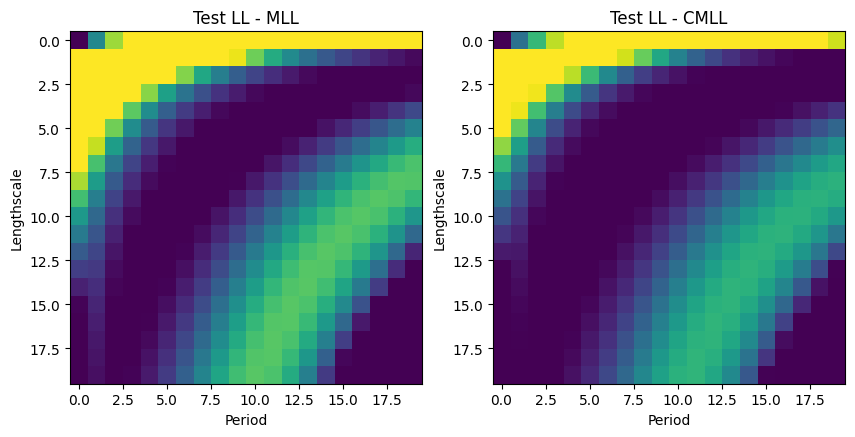

In [19]:
cmap='viridis'
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
AxPlotter(ax[1], plt_error-plt_cmll, title="Test LL - CMLL")
AxPlotter(ax[0], plt_error-plt_mll, title="Test LL - MLL")

Text(0, 0.5, 'Scaled Log-Likelihood')

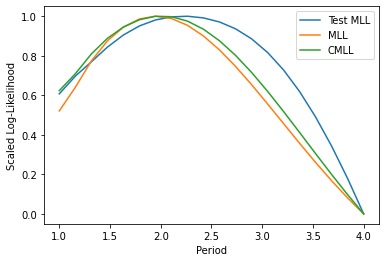

In [20]:
idx = 12
plt.plot(period_array,rescale(plt_error[idx, :]), label="Test MLL")
plt.plot(period_array,rescale(plt_mll[idx, :]), label="MLL")
plt.plot(period_array,rescale(plt_cmll[idx, :]), label="CMLL")

plt.legend()
plt.xlabel("Period")
plt.ylabel("Scaled Log-Likelihood")

## Effect of `m`

In [21]:
ls = lengthscale_array[12]
period_array = torch.linspace(0.01, 3., 30)

nshuffle = 10
ms = np.array([10, 20, 24])

error_array = torch.zeros(period_array.shape[0])
mll_array = torch.zeros(period_array.shape[0])
cmll_array = torch.zeros(period_array.shape[0], ms.shape[0], nshuffle)

In [22]:

for p_idx, p in enumerate(period_array):
    kernel = PeriodicKernel()
    kernel.lengthscale = ls
    kernel.period_length = p

    ## Compute Error LL  and MLL ##
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.noise = true_noise
    gp = ExactGPModel(
        train_x=train_x,
        train_y=train_y,
        likelihood=likelihood,
        kernel=kernel
    ).to(x.device)

    gp.eval()
    likelihood.eval()
    f_preds = gp(eval_x)
    y_preds = likelihood(f_preds)
    error_array[p_idx] = y_preds.log_prob(eval_y).item()
    mll_array[p_idx] = get_mll(gp, train_x, train_y).item()

    
for s_idx in range(nshuffle):
    order = torch.randperm(train_x.shape[0])
    for m_idx, m in enumerate(ms):
        xm = train_x[order[:m]]
        xstar = train_x[order[m:]]

        ym = train_y[order[:m]]
        ystar = train_y[order[m:]]
        for p_idx, p in enumerate(period_array):

            kernel = PeriodicKernel()
            kernel.lengthscale = ls
            kernel.period_length = p
            gp = ExactGPModel(
                train_x=xm,
                train_y=ym,
                likelihood=likelihood,
                kernel=kernel
            ).to(x.device)

            cmll_array[p_idx, m_idx, s_idx] = get_conditional_mll(gp, train_x, train_y, xm, ym).item()


In [23]:
def rescale(lst):
    lst = np.array(lst)
    return (lst - np.min(lst)) / (np.max(lst - np.min(lst)))

In [25]:
mean_cmll = cmll_array.mean(-1)
plt_cmll = np.zeros(mean_cmll.shape)
for r in range(mean_cmll.shape[-1]):
    plt_cmll[:, r] = rescale(mean_cmll[:, r].detach())
plt_error = rescale(error_array.detach())
plt_mll = rescale(mll_array.detach())


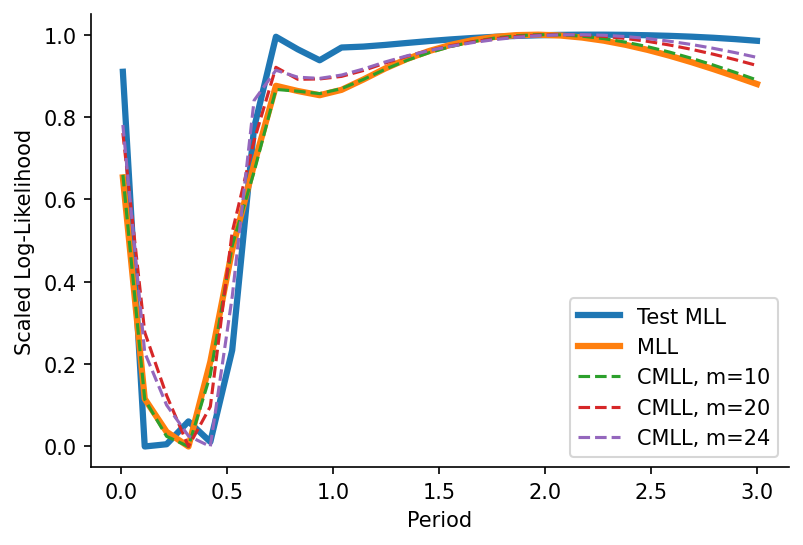

In [26]:
plt.subplots(dpi=150)
plt.plot(period_array, plt_error, label="Test MLL", lw=3.)
plt.plot(period_array, plt_mll, label="MLL", lw=3.)
plt.plot(period_array, plt_cmll[:, 0], label="CMLL, m=10", ls='--')
plt.plot(period_array, plt_cmll[:, 1], label="CMLL, m=20", ls='--')
plt.plot(period_array, plt_cmll[:, 2], label="CMLL, m=24", ls='--')
plt.legend()
plt.xlabel("Period")
plt.ylabel("Scaled Log-Likelihood")
sns.despine()

# Spectral Mixture

## Exponentially Decaying Sine Data

In [331]:
def DataGen(x, freq=10., noise=0.1, seed=33):
    torch.manual_seed(seed)
    return torch.exp(-x) * torch.sin(freq*x) + noise * torch.randn(x.shape)

In [351]:
x = torch.linspace(0, 3., 200)
true_noise = 0.1
y = DataGen(x, noise=true_noise)

In [352]:
use_cuda = False
if torch.cuda.is_available():
    use_cuda = True
    x = x.cuda()
    y = y.cuda()

In [353]:
shuffle = torch.randperm(x.shape[0])
ntrain = 50
train_x = x[shuffle[:ntrain]]
eval_x = x[shuffle[ntrain:]]

train_y = y[shuffle[:ntrain]]
eval_y = y[shuffle[ntrain:]]

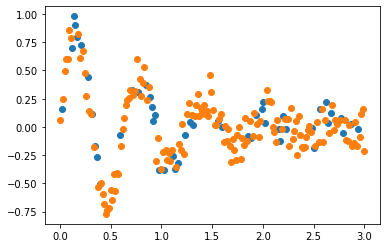

In [355]:
plt.scatter(train_x.cpu(), train_y.cpu())
plt.scatter(eval_x.cpu(), eval_y.cpu())

In [367]:
ls = lengthscale_array[12]
period_array = torch.linspace(0.1, 10., 50)

nshuffle = 10
ms = np.array([30, 40, 49])

error_array = torch.zeros(period_array.shape[0])
mll_array = torch.zeros(period_array.shape[0])
cmll_array = torch.zeros(period_array.shape[0], ms.shape[0], nshuffle)

In [368]:
mixture_scale = 0.25

for p_idx, p in enumerate(period_array):
    kernel = SpectralMixtureKernel(num_mixtures=1)
    kernel.mixture_means = p
    kernel.mixture_scales = mixture_scale
    
    ## Compute Error LL  and MLL ##
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.noise_covar.noise = true_noise
    gp = ExactGPModel(
        train_x=train_x,
        train_y=train_y,
        likelihood=likelihood,
        kernel=kernel
    ).to(x.device)

    gp.eval()
    likelihood.eval()
    f_preds = gp(eval_x)
    y_preds = likelihood(f_preds)
    error_array[p_idx] = y_preds.log_prob(eval_y).item()
    mll_array[p_idx] = get_mll(gp, train_x, train_y).item()

    
for s_idx in range(nshuffle):
    order = torch.randperm(train_x.shape[0])
    for m_idx, m in enumerate(ms):
        xm = train_x[order[:m]]
        xstar = train_x[order[m:]]

        ym = train_y[order[:m]]
        ystar = train_y[order[m:]]
        for p_idx, p in enumerate(period_array):
            kernel = SpectralMixtureKernel(num_mixtures=1)
            kernel.mixture_means = p
            kernel.mixture_scales = mixture_scale
            gp = ExactGPModel(
                train_x=xm,
                train_y=ym,
                likelihood=likelihood,
                kernel=kernel
            ).to(x.device)

            cmll_array[p_idx, m_idx, s_idx] = get_conditional_mll(gp, train_x, train_y, xm, ym).item()


In [369]:
def rescale(lst):
    lst = np.array(lst)
    return (lst - np.min(lst)) / (np.max(lst - np.min(lst)))

In [370]:
mean_cmll = cmll_array.mean(-1)
plt_cmll = np.zeros(mean_cmll.shape)
for r in range(mean_cmll.shape[-1]):
    plt_cmll[:, r] = rescale(mean_cmll[:, r].detach())
plt_error = rescale(error_array.detach())
plt_mll = rescale(mll_array.detach())


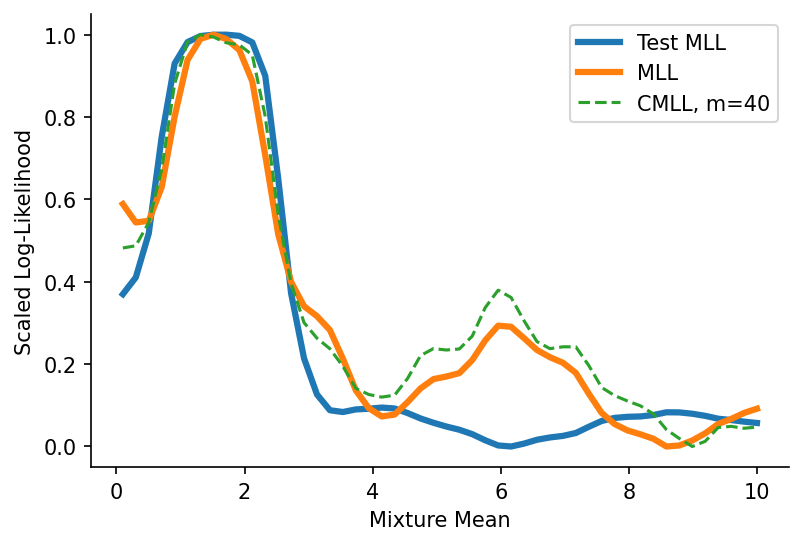

In [371]:
plt.subplots(dpi=150)
plt.plot(period_array, plt_error, label="Test MLL", lw=3.)
plt.plot(period_array, plt_mll, label="MLL", lw=3.)
# plt.plot(period_array, plt_cmll[:, 0], label="CMLL, m=" + str(ms[0]), ls='--')
plt.plot(period_array, plt_cmll[:, 1], label="CMLL, m=" + str(ms[1]), ls='--')
# plt.plot(period_array, plt_cmll[:, 2], label="CMLL, m=" + str(ms[2]), ls='--')
plt.legend()
plt.xlabel("Mixture Mean")
plt.ylabel("Scaled Log-Likelihood")
sns.despine()

## What's up With These Predictions

In [329]:
kernel = SpectralMixtureKernel(num_mixtures=1)
kernel.mixture_means = 0.0001
kernel.mixture_scales = 1.

## Compute Error LL  and MLL ##
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = true_noise
gp = ExactGPModel(
    train_x=train_x,
    train_y=train_y,
    likelihood=likelihood,
    kernel=kernel
).to(x.device)

gp.eval();
pred_dist = gp(x)
short_mean = pred_dist.mean.cpu()
short_lwr, short_upr = pred_dist.confidence_region()



kernel = SpectralMixtureKernel(num_mixtures=1)
kernel.mixture_means = 2.
kernel.mixture_scales = 1.

## Compute Error LL  and MLL ##
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise_covar.noise = true_noise
gp = ExactGPModel(
    train_x=train_x,
    train_y=train_y,
    likelihood=likelihood,
    kernel=kernel
).to(x.device)

gp.eval();
pred_dist = gp(x)
long_mean = pred_dist.mean.cpu()
long_lwr, long_upr = pred_dist.confidence_region()

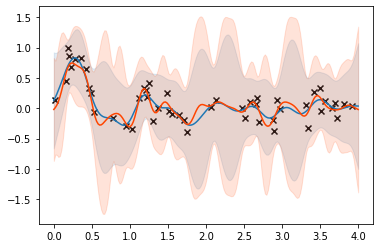

In [330]:
plt.scatter(train_x.cpu(), train_y.cpu(), marker='x', color='k')
plt.plot(x.cpu(), short_mean.detach())
plt.fill_between(x.cpu(), short_lwr.detach().cpu(), short_upr.detach().cpu(), color='steelblue', alpha=0.15)
plt.plot(x.cpu(), long_mean.detach(), color='OrangeRed')
plt.fill_between(x.cpu(), long_lwr.detach().cpu(), long_upr.detach().cpu(), color='OrangeRed', alpha=0.15)